Apply the Optimization code to predict dolphin hunting parties of [3, 4, 6, 8, 10] with the conditions that the cost function increase by square of the pairwise distance if the dolphins are too far apart, and increases by inverse square of the pairwise distance if they are too close together.

a.) Below I modified the Nelder Mead code, from plotting x, y, and volume surface plot, to plotting x, y, z points on a scatter plot. the volume cost function is thus replaced with the distance_cost_func which calculated the pairwise distance for each dolphin on Line 170. I would predict that the dolphins should form some type of symmetrical sphere around the prey (in this case the origin). 


b.) Justifying why I believe the dolphins should for a symmetric sphere is to maximize their distance from each other but minimize the gaps for the prey to escape. If the dolphins were in a 2D circle, the prey could swim up and not get caught. So including the 3rd dimension is ideal. If too many dolphins are on one side of the sphere, there is more opportunity for the prey to swim in the direction of fewer dolphins. 

There is one issue with the current setup, however even so, the correct positioning of 3 can always be seen. The issue is that with the random() to initialize the simplex, some dolphins may be close to each other and others far apart. The optimization causes these dolphins who are close together to for a type of subset together. This occurs mostly in groups of 3. The dolphins further away then optimize with this subset of 3. If one could find a specific seed for the initial points, one could find a more consistent and balanced optimization. 

Because of this issue, I do not believe that the data is optimal. In fact no spherical configurations are made To fix this issue one would have to set the dolphins positions such that these small groups do not form. If we want the dolphins to start at random points, one might set a minimum distance between each dolphin such that the dolphins cannot form these subsets. 

Setting the seed in line 188 can be used to get consistent plots. Testing a couple I found:
3 and 4 configurations are pretty much the same type of configuration.
5: 6 dolphins good except a straggler
42: pretty good, subsets emerge in each plot
35: 10 dolphins looks ok, a circle is made, but not optimal

[3.82520819 1.59404105 3.24027409] [2.57502172 4.69571216 1.43169751] [1.93314392 0.63978155 3.52857848]


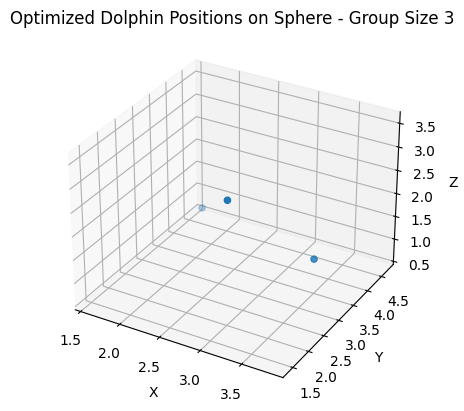

[3.37365939 4.96775203 2.59514573 2.10485413] [2.92616911 0.11221267 4.01622562 2.71603889] [2.24854545 0.55574103 1.4612154  3.63217866]


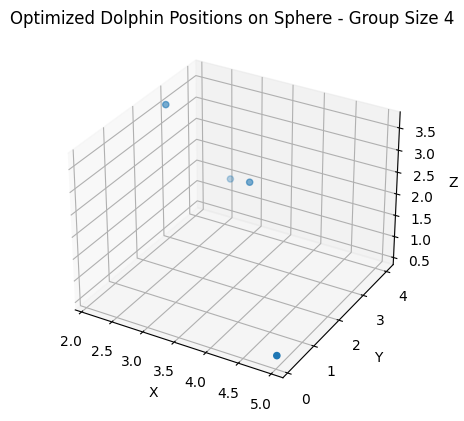

[0.11718869 4.65486801 3.43321135 2.26559782 1.80553665 1.62784655] [3.75780307 0.39009172 3.63488754 3.36442758 4.17913009 2.0687349 ] [3.29623769 1.78326451 0.02554197 2.92364388 2.06758534 4.25093537]


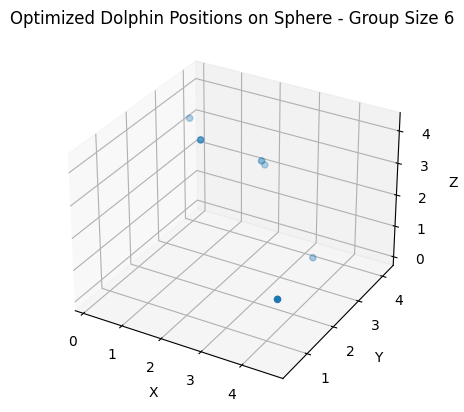

[0.31668239 4.39726161 3.80166387 2.2386979  3.85909859 2.39867427
 3.21009952 0.03146113] [4.98951139 0.18270341 0.08766997 0.17538014 2.22240804 3.70739817
 2.27212074 3.38867826] [0.06699542 2.37291167 3.24648514 4.46737882 2.27338087 2.34554056
 3.08751169 3.67639359]


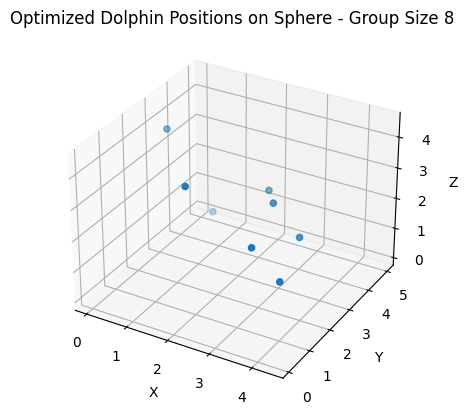

[1.349677   4.27900112 0.71092961 0.42672633 2.1373135  1.41461686
 2.09133184 2.96725288 4.23814755 3.45095596] [3.55201443 0.98999578 4.6294962  2.5494959  3.73467763 1.3118797
 4.09701538 2.75710223 0.91822058 2.14056364] [3.24985623 2.38957272 1.74995542 4.27995039 2.54638449 4.61278992
 1.95979492 2.93151798 2.48897093 2.91700022]


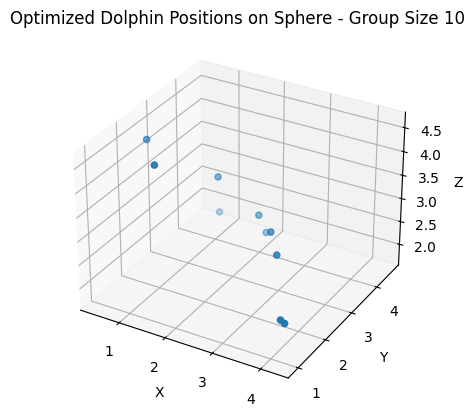

In [12]:
import numpy as np
import matplotlib.pyplot as plt

"""
Title: Evolve & Orbit
Author & Credit to: Sagar Pandit
Modified by: Peter Kveton
Date: 12/2/23

"""


class Nelder_Mead:
    def __init__(self, dim, distance_cost_func, param=None):
        self.dim = dim
        self.simplex = np.zeros(dim*(dim + 1))
        self.simplex = np.reshape(self.simplex, (dim + 1, dim))
        self.param = param
        self.distance_cost_func = distance_cost_func
        self.val = np.zeros(dim + 1)
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.delta = 0.5
        

    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            self.val[index] = self.calculate_cost(entry)
            return self.val[index], self.simplex[index]


    def __getitem__(self, index):
        return self.get(index)


    def __setitem__(self, index, entry):
        return self.get(index, entry)


    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]


    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]


    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max):
            p_bar += self.simplex[i]
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]
        p_bar = p_bar/self.dim
        return p_bar


    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p


    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar


    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar


    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl


    def rmsd(self):
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))


    def calculate_cost(self, entry):
        # With the new cost function, we add a definition to get the function depending on weather we have a parameter or not.
        if self.param is None:
            return self.distance_cost_func(entry)
        else:
            return self.distance_cost_func(entry, self.param)


    def nelder_mead_step(self):
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        val_r = self.calculate_cost(p_r)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            val_ex = self.calculate_cost(p_ex)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'
            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'

        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                val_c = self.calculate_cost(p_c)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                val_c = self.calculate_cost(p_c)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
                
                
    def initialize_simplex(self):
        # Initialize simplex based on the number of dolphins
        # Rather than inputting v, s = nm.get for random initial positions, I modified the code to use the np.random feature to get random initial points
        self.simplex = np.random.rand(self.dim + 1, self.dim)


    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            #print(val, index, rms, step_name)
        return self.simplex[index]


def distance_cost_func(dolphins):
    # The cost function here has 2 conditions
    # Here we get the pairwise distance between each dolphin, making sure that each calculation is only performed once. We use the np.square command to get the square of each term in the pairwise distance
    far_apart_cost = 0.01 * sum(np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) > 2)
    # The differance here is that we have the inverse square or 1/np.square
    too_close_cost = 0.01 * sum(1 / np.square(np.linalg.norm(d1 - d2)) for i, d1 in enumerate(dolphins) for j, d2 in enumerate(dolphins) if i != j and np.linalg.norm(d1 - d2) < 1)
    return far_apart_cost + too_close_cost


def normalize_to_sphere(x, num_dolphins, radius=1.0):
    x = x.reshape(num_dolphins, -1)
    norm = np.linalg.norm(x, axis=1)
    normalized_x = radius * x / norm[:, np.newaxis]
    return normalized_x.flatten()


if __name__ == '__main__':
    
    np.random.seed(35)  # Set seed for reproducibility
    group_sizes = [3, 4, 6, 8, 10]


    for num_dolphins in group_sizes:
        # The dimensionality depends on the 3D dimensions times the number of dolphins
        nm = Nelder_Mead(num_dolphins * 3, distance_cost_func)
        # Like stated above we make a function to set the matrices, rather than writing an in initial point for each dolphin
        nm.initialize_simplex()
        x = nm.optimize()
        # Normalize to ensure positions are on a sphere with radius 5.0 (adjust as needed)
        x = normalize_to_sphere(x, num_dolphins, radius=5.0)
        # Coordinates of each data point 
        print(x[::3], x[1::3], x[2::3])
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[::3], x[1::3], x[2::3])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Optimized Dolphin Positions on Sphere - Group Size {num_dolphins}')
        plt.show()